# Goal

We've developed an ice-sheet model emulator for both the RCP8.5 scenario and the LIG scenario in **construct_rcp_emulator.ipynb** and **construct_lig_emulator.ipynb** respectively.

The purpose of sampling from the LIG emulator is to inform our sampling of the RCP8.5 emulator, and for that we need LIG observational constraints. In this code we develop posterior distributions of CREVLIQ and CLIFVMAX, illustrating how assumptions about the shape and magnitude of the LIG observational record influences those posteriors.

The specific LIG constraint distributions are drawn from the results of **sample_lig_emulator.ipynb**. We explore the following constraint distributions:

- Unconstrained: Distribution with uniform equal weights across all parameters
- D20-U: DeConto et al. (2020) Uniform distribution
- D20-N: DeConto et al. (2020) distribution Assumed Gaussian
- E19-U: Edwards et al. (2020) Uniform distribution based on DeConto and Pollard (2016)
- K09-125ka: Kopp et al. (2009) GP Distribution Time Slice at 125ka
- K09-Max-3kyrSmooth: Kopp et al. (2009) GP Distribution Maximums of Samples (smoothed over 3kyr)

We also explore the effects of two sets of hypothetical LIG constraints:

- High and low distributions: Assuming LIG AIS>6 m and LIG AIS<3.5 m, respectively
- Narrower D20-U: Sensitivity to reduced uncertainties in LIG estimates

Additionally, we compute RCP8.5 distributions as a function of (conditional on) LIG sea level contributions.

# Setup

In [1]:
# import the relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy

In [2]:
# define the colormap
plt.set_cmap('viridis')
# define the save path for our plots
save_path='./figures/'
# import a series of colors for the prior vs. constraints plot
from lig_utilities import call_scm_cmap, uniform_cmap_slices
cmap=call_scm_cmap('roma')
cols=uniform_cmap_slices(cmap,5,col_range=[0,1.0])[::-1]
# import the rectangle feature
import matplotlib.patches as patches
# set the default grid style
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5

<Figure size 432x288 with 0 Axes>

In [3]:
# import the GPflow package to load the GP model and sample
import gpflow
from lig_utilities import normalize, denormalize
# load the modules to compute the statistics
from lig_utilities import posterior_densities_rcp85, find_quantile_i, find_quantile_ts
# import tensorflow so we can restore the trained model
import tensorflow as tf

# Data and Model

Restore the trained GPflow model for RCP8.5 from which to sample.

### Load the Training Data (to reconstruct the GP model)

In [4]:
# load the training data from the pickle and print its keys
train_dat=pickle.load(open( "./models/rcp_model_traindata.pk1", "rb" ) )
train_dat.keys()

dict_keys(['clifvmax', 'Y_train', 'model_name', 'kernel_code', 'crevliq', 'time', 'X_train'])

### Restore the Trained GP model

In [5]:
# reconstruct the GP model
with gpflow.defer_build():
    
    # define the kernel
    k = eval(train_dat['kernel_code'])

    # create the model
    m = gpflow.models.GPR(train_dat['X_train'], \
        train_dat['Y_train'].reshape(np.size(train_dat['Y_train']),1), kern=k, name=train_dat['model_name'])
    
    # Fix the nugget term
    m.likelihood.variance = 1e-06
    m.likelihood.trainable=False
  
# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_graph = m.enquire_graph()
tf_session = m.enquire_session()
m.compile( tf_session )

# create the saver object and load the archived model object
saver = tf.train.Saver()
save_path = saver.restore(tf_session, "./models/rcp_model.ckpt")
print("Model loaded from path: %s" % save_path)

# anchor the model to restore optimized hyperparameters
m.anchor(tf_session)

INFO:tensorflow:Restoring parameters from ./models/rcp_model.ckpt


INFO:tensorflow:Restoring parameters from ./models/rcp_model.ckpt


Model loaded from path: None


In [6]:
# uncomment to verify the hyperparameters are correctly restored
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
rcp_model/kern/kernels/0/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,0.5012107704313864
rcp_model/kern/kernels/0/kernels/0/variance,Parameter,None,+ve,True,(),True,1.830591620175421
rcp_model/kern/kernels/0/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,0.4548666355127329
rcp_model/kern/kernels/0/kernels/1/variance,Parameter,None,+ve,True,(),True,1.8310064734237486
rcp_model/kern/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,2.7567453807220614
rcp_model/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,2731.897366783309
rcp_model/likelihood/variance,Parameter,None,+ve,False,(),True,1e-06


### Load the LHC Design

In [8]:
# load the design from pickle
lhd=pickle.load(open( "./models/lig_lhc_design_10000.pk1", "rb" ) )
n_samples=len(lhd)

### Define Normalized Time grid for Sampling

In [9]:
# define the normalized time grid, every ten years from 1995 to 2200
sample_time=np.linspace(0,1.0,22)
#denorm_time=denormalize(sample_time,np.max(train_dat['time']),np.min(train_dat['time']))
denorm_time=denormalize(sample_time,2200,1990)
print(denorm_time)

[ 1990.  2000.  2010.  2020.  2030.  2040.  2050.  2060.  2070.  2080.
  2090.  2100.  2110.  2120.  2130.  2140.  2150.  2160.  2170.  2180.
  2190.  2200.]


Note that the emulator will be truncated at 2150 in our analyses to reduce edge effects in the GP model emulator.

# Sampling and Results

With the data loaded in, and the GP model restored, we now sample from the model, weighting the samples according to the CREVLIQ/CLIFVMAX set likelihoods associated with each set of different LIG constraints (developed and saved out in **sample_lig_emulator.ipynb**). 

We find posterior distributions of the sea level samples and plot their timeseries.

## Prior RCP8.5 Distribution

The "prior" is given by assuming that all CREVLIQ/CLIFVMAX contributions are equally likely, i.e. the emulator is unconstrained over the parameter range of the training ensemble.

In the process of finding the prior below, we use the modules needed to condition our posteriors and plot the PDFs of sea level contributions from AIS through time.

In [10]:
# create the sample grid with the LHC design (at each time point)
X_sample=np.empty((len(lhd)*len(sample_time),3),dtype='float')
for t in range(len(sample_time)):
    
    # index in array creation
    t_first=t*len(lhd)
    t_last=t_first+len(lhd)
    
    # fill an array with out time period
    t_fill=np.empty(len(lhd))
    t_fill.fill(sample_time[t])
    
    # fill the sample grid array
    X_sample[t_first:t_last,:]=np.vstack((np.vstack((t_fill[:],lhd[:,0])),lhd[:,1])).T

In [11]:
# sample from the model
sample_mean,sample_var=np.squeeze(m.predict_y(X_sample))

# reshape into the prior
prior_mean=sample_mean.reshape(len(sample_time),len(lhd))
prior_var=sample_var.reshape(len(sample_time),len(lhd))

In [13]:
# get the time location for thge plot
ind2100=np.where(denorm_time==2100)
ind2150=np.where(denorm_time==2150)

### Calculate and Visualize the Prior

In [17]:
# import the scipy packages needed to define distrubutions
from scipy.stats import norm

# define the prior pdf from the GP emulator, note that its properties/methods (e.g. "pdf")
# will have shape (ntime,nsamples) (i.e. or the same as "prior_mean"/"prior_var")
prior_norm=norm(loc=prior_mean,scale=np.sqrt(prior_var))

# create the bins to perform our density estimation
sl_step=1e-03
min_val,max_val=-0.5,9.5
step_locs=np.arange(min_val,max_val+sl_step,step=sl_step)

# Posterior Probability Distributions at specific times

To show the value of LIG constraints for informing future projections, we plot the posterior probability distribution functions associated with each LIG constraint distribution specified above. These PDFs are simply timeslices of the above timeseries in 2100 and 2150.

## 2100 PDFs

In [39]:
denorm_time

array([ 1990.,  2000.,  2010.,  2020.,  2030.,  2040.,  2050.,  2060.,
        2070.,  2080.,  2090.,  2100.,  2110.,  2120.,  2130.,  2140.,
        2150.,  2160.,  2170.,  2180.,  2190.,  2200.])

In [42]:
minval_2100,maxval_2100=-0.5,1.5
hist_bins=np.arange(minval_2100,maxval_2100+sl_step*1e01,step=sl_step*1e01)

## RCP8.5 Conditional Probability Distributions as a function of the LIG

Here we explore what very narrow constraints on the LIG distribution---i.e., assuming that changes during the LIG were known to within 10cm---would mean for the distribution of the RCP8.5 projections. This approach to find the conditional probabilities is both generalized and useful in specific ways, e.g. one can integrate over the distributions shown here with weightings from specific constraints to recover the associated posterior of the RCP8.5 distribution.

For every 10-cm-wide constraint (which is considered a uniform distribution of 10cm width, see **sample_lig_emulator.ipynb**), there is a likelihood of CREVLIQ/CLIFVMAX values at each sample location. Using those likelihoods, we determine the RCP8.5 distribution conditional on the LIG.

### Load data for conditional probability analyses:

In [58]:
# load the idealized array data dictionary
idealized_dat=pickle.load(open( "./models/lig_posteriors.pk1", "rb" ) )
# get the number of bins
n_bins=len(idealized_dat['lig_posteriors'])
print(n_bins)

51


### Sample the LIG and RCP8.5 emulators with the weights associated with each 10-cm-wide bin

In [59]:
# limit the distributions to just 2100 and 2150, by building a new (limited over to these two times) prior:
index_nums = [ind2100,ind2150]
prior_mean_slice = np.squeeze([prior_mean[val,:] for val in index_nums])
prior_var_slice  = np.squeeze([prior_var[val,:] for val in index_nums])
denorm_time_slice= np.squeeze([denorm_time[val] for val in index_nums])
prior_norm_slice=norm(loc=prior_mean_slice,scale=np.sqrt(prior_var_slice))

In [60]:
# define the LIG bins to perform the idealized density estimation
slid_step=1e-02
idealized_step_locs=np.arange(min_val,max_val+slid_step,step=slid_step)
# define the RCP85 to perform the idealized density estimation
step_locs_2100=idealized_step_locs
step_locs_2150=np.arange(min_val,max_val+slid_step*1e1,step=slid_step*1e1)

In [61]:
# create the array that we need for storing analysis
posterior_pdfs_2100=np.empty((n_bins,len(step_locs_2100)),dtype='float')
posterior_pdfs_2150=np.empty((n_bins,len(step_locs_2150)),dtype='float')

# loop over bins to find the posterior quantiles
for b in range(n_bins):
    
    # find the posterior RCP for this bin
    post_bin_2100=posterior_densities_rcp85(step_locs_2100,denorm_time_slice,prior_norm_slice,idealized_dat['lig_posteriors'][b]['param_density'])
    post_bin_2150=posterior_densities_rcp85(step_locs_2150,denorm_time_slice,prior_norm_slice,idealized_dat['lig_posteriors'][b]['param_density'])
    
    # store the RCP samples at 2100 and 2150
    posterior_pdfs_2100[b,:]=np.squeeze(post_bin_2100['posterior_ts'][:,0])
    posterior_pdfs_2150[b,:]=np.squeeze(post_bin_2150['posterior_ts'][:,1])
    
    # normalize the result in each column
    posterior_pdfs_2100[b,:]=posterior_pdfs_2100[b,:]/np.sum(posterior_pdfs_2100[b,:])
    posterior_pdfs_2150[b,:]=posterior_pdfs_2150[b,:]/np.sum(posterior_pdfs_2150[b,:])
    
    # tell the user where we are
    print(b)
    
    # delete things before starting a new loop
    del post_bin_2100
    del post_bin_2150

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


### Plot the Results in 2100 and 2150

In [62]:
# color levels necessary for the contouring
clevels=np.linspace(np.log(1e-3),np.log(0.3),11)
clabels=np.round(np.exp(clevels),decimals=3).astype('str')

<style>
    .sm     {font-size: 14pt; color: black; font-family: 'Times New Roman';}
</style>

<ol style="font-size: 34pt; color: red;">
<li> idealized_dat <p class=sm><b>cell 58 </b>idealized_dat=pickle.load(open( "./models/lig_posteriors.pk1", "rb" ) )</li></p>
<li style="color: green;">> idealized_step_locs </li>  
<p class=sm> <span style="color: green;"> <b>cell 60</b> idealized_step_locs=np.arange(min_val,max_val+slid_step,step=slid_step) <br></style>
    > min_val,max_val+slid_step are prescribed in <b>cell 17</b></p>
<li> np.log(posterior_pdfs_2100.T) </li> 
    <p class=sm> <span style="color: green;"> <b>cell 61</b> posterior_pdfs_2100=np.empty((n_bins,len(step_locs_2100)),dtype='float')
</ol>

/home/dmg370/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


<Figure size 432x288 with 0 Axes>

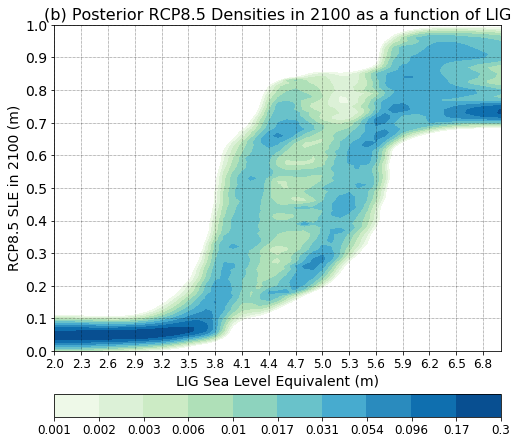

In [63]:
# plot the result for 2100
plt.set_cmap('GnBu')
lig_rcp_jointpdf_2100_fig=plt.figure(figsize=(8,8))
c1=plt.contourf(idealized_dat['idealized_mid_steps'],idealized_step_locs,np.log(posterior_pdfs_2100.T),clevels)
cbar=plt.colorbar(c1,ticks=clevels,orientation='horizontal',pad=0.1)
cbar.set_ticklabels(clabels)
cbar.ax.tick_params(labelsize=12)
plt.xticks(idealized_dat['idealized_mid_steps'][::3],fontsize=12)
plt.yticks(np.linspace(0.,1.0,11),fontsize=14)
plt.ylim([0,1.0])
plt.xlim([2.,7.0])
plt.title('(b) Posterior RCP8.5 Densities in 2100 as a function of LIG',fontsize=16)
plt.xlabel('LIG Sea Level Equivalent (m)',fontsize=14)
plt.ylabel('RCP8.5 SLE in 2100 (m)',fontsize=14)
plt.grid()
plt.show()

In [64]:
# save the plot out
savename='Fig4b.pdf'
lig_rcp_jointpdf_2100_fig.savefig(save_path+savename)

## Save out Data

In [71]:
# store and save the data from the conditional calculations
output_dat={'conditional_dat':idealized_dat, 'posterior_2100':posterior_pdfs_2100, 'posterior_2150':posterior_pdfs_2150,'step_locs_2100':step_locs_2100,'step_locs_2150':step_locs_2150}
pickle.dump(output_dat, open( "./models/conditional_data.pk1", "wb" ) )

## Table of Quantiles

Here we print the quantiles that we found above in 2100 and 2150, in meters.

In [73]:
import pandas as pd
ind2100=np.where(denorm_time==2100)
ind2150=np.where(denorm_time==2150)
stack_2100=np.hstack((quants_prior[:,ind2100],quants_D20_U[:,ind2100],quants_D20_N[:,ind2100], \
                                    quants_e19_U[:,ind2100],quants_k09_125[:,ind2100], \
                                    quants_k09_max_3kyr[:,ind2100]))
stack_2150=np.hstack((quants_prior[:,ind2150],quants_D20_U[:,ind2150],quants_D20_N[:,ind2150], \
                                    quants_e19_U[:,ind2150],quants_k09_125[:,ind2150], \
                                    quants_k09_max_3kyr[:,ind2150]))
frame_2100=pd.DataFrame(np.squeeze(stack_2100),columns=['Prior','D20-U','D20-N','E19-U','K09-125ka','K09-Max-3kyrSmooth'],index=q)
frame_2150=pd.DataFrame(np.squeeze(stack_2150),columns=['Prior','D20-U','D20-N','E19-U','K09-125ka','K09-Max-3kyrSmooth'],index=q)

In [74]:
# change the number of precision digits to show in Pandas
pd.set_option('precision', 2)

In [75]:
frame_2100

,Prior,D20-U,D20-N,E19-U,K09-125ka,K09-Max-3kyrSmooth
5,0.07,0.07,0.07,0.07,0.07,0.09
25,0.20,0.20,0.23,0.23,0.22,0.32
50,0.42,0.40,0.40,0.44,0.43,0.53
75,0.64,0.61,0.58,0.65,0.64,0.72
95,0.85,0.83,0.78,0.85,0.85,0.88


In [76]:
frame_2150

,Prior,D20-U,D20-N,E19-U,K09-125ka,K09-Max-3kyrSmooth
5,0.44,0.44,0.51,0.52,0.46,0.65
25,1.21,1.17,1.23,1.30,1.25,1.65
50,2.31,2.21,2.18,2.39,2.34,2.84
75,3.54,3.38,3.22,3.58,3.55,3.91
95,4.65,4.56,4.38,4.66,4.64,4.80
